In [1]:
import anndata
import pandas as pd
import numpy as np
from pandas import *
from sklearn import preprocessing
import random
from pathlib import Path
import pickle
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
from PIL import Image
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import scanpy as sc
import warnings
warnings.simplefilter('ignore')

/hdd1/home/p22_cyyeung/miniconda3/envs/scrna/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
path = "./pretrain_less_class_2"
input_query = sc.read_h5ad("external_data/liver_breast_external.h5ad")

#input_query = sc.read_h5ad("met_data/GSE131907.h5ad")

In [3]:
input_query.var['mt'] =  input_query.var.index.str.startswith('MT-')
#label ribosomal gene
ribo_url = "https://www.genenames.org/cgi-bin/genegroup/download?id=1054&type=branch"
ribo_gene = pd.read_table(ribo_url)
input_query.var['ribo'] = input_query.var_names.isin(ribo_gene["Approved symbol"].values)


sc.pp.calculate_qc_metrics(input_query, qc_vars = ['mt', 'ribo'], percent_top = None, log1p = False, inplace = True)
input_query = input_query[input_query.obs.pct_counts_mt < 25]
sc.pp.filter_cells(input_query, min_genes = 500)
sc.pp.filter_genes(input_query, min_cells = 10)
input_query = input_query[:,~(input_query.var.ribo | input_query.var.mt)]

In [4]:
#gene_list = pd.read_csv(Path(path, "pretrained_genes.csv"), index_col=0).index.tolist()
#remain_list = list(set(input_query.var.index) & set(gene_list))
#input_query = input_query[:,remain_list]
sc.pp.normalize_per_cell(input_query)
sc.pp.log1p(input_query)
#sc.pp.combat(input_guery, key='batch', inplace=True)
input_query

AnnData object with n_obs × n_vars = 3862 × 18404
    obs: 'cell_type', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p'

In [ ]:
#input_query = input_query[~input_query.obs.index.isin(ref_list)]
#input_query

In [6]:
# Perform the same scaling method as the pre-training process.
min_max_scaler = preprocessing.MinMaxScaler()
sample = pd.DataFrame(input_query.X.toarray())
sample = sample.transpose()
sample = min_max_scaler.fit_transform(sample)
sample = pd.DataFrame(sample)
sample = sample.transpose()
sample.index = input_query.obs.index.values
sample.columns = input_query.var.index.values

# Check sample dataset.

In [18]:
gene_list = pd.read_csv(Path(path, "./pretrained_genes.csv"))
gene_list = gene_list.iloc[:, 0]
gene_list = gene_list.to_list()
# Fill zero when genes of the pre-trained model are not included in the sample dataset.
genes = sample.columns.values.tolist()
excluded_genes = list(set(gene_list) - set(genes)) 
blank_dataframe = pd.DataFrame(np.zeros((len(sample.index.tolist()), len(excluded_genes))))
blank_dataframe.index = sample.index.tolist()
blank_dataframe.columns = excluded_genes
sample = pd.concat([sample, blank_dataframe], axis=1)
sample = sample[gene_list]
# Check sample data after filling missing genes that are not contained in the query dataset.
sample

,SAMD11,HES4,ISG15,MXRA8,VWA1,MIB2,GABRD,RP11-547D24.3,RP11-181G12.4,TNFRSF14,...,CBS,PDXK,CSTB,LINC00162,COL18A1,AL592528.1,COL6A1,COL6A2,FTCD,S100B
CID3921_CCCAATCGTGTGCCTG,0.0,0.080500,0.000000,0.140773,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.062748,0.381713,0.0,0.000000,0.0,0.043588,0.0,0.0,0.0
CID3921_CTCTGGTTCTGGTATG,0.0,0.000000,0.000000,0.000000,0.000000,0.047770,0.0,0.0,0.0,0.000000,...,0.0,0.086058,0.319158,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
CID3921_GAAACTCCAGACGCTC,0.0,0.035538,0.211167,0.000000,0.093463,0.000000,0.0,0.0,0.0,0.105924,...,0.0,0.018454,0.422224,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
CID3921_GGTGCGTGTTTGCATG,0.0,0.254092,0.101038,0.000000,0.000000,0.029991,0.0,0.0,0.0,0.000000,...,0.0,0.101038,0.420320,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
CID3921_TGGGCGTAGTCATCCA,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTAGGTCGGCCGAT-22,0.0,0.000000,0.000000,0.000000,0.246572,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.246572,0.347643,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
TTTACTGGTCTGGTCG-22,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.204662,0.0,0.000000,0.0,0.0,0.0
TTTATGCAGGAGTAGA-22,0.0,0.000000,0.000000,0.000000,0.234108,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.406158,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
TTTGTCAAGACTACAA-22,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.266467,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [19]:
# Use the trained image transormer to tansform the sample dataset.
# Input 4: Provided trained image transformer.
file = open(Path(path, "img_transformer_pre.obj"),'rb')
it = pickle.load(file)
file.close()
query_img = (it.transform(sample)*255).astype(np.uint8)
#Store the generated images of the sample query dataset.
np.save(Path(path, "sample.npy"), query_img)

In [20]:
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

# Use generated images of query data as the input of pre-trained model.
test = MyTestSet(Path(path, "sample.npy"))
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

# The pre-trained model can identify 31 cell types, so num_classes is 31.
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=12)
# Prioritize using GPUs to load the model. 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)

mod.to(device)
mod = mod.to(device)

torch.set_num_threads(15)
# Use pre-trained model to predict cell types on the sample query dataset.
# Input 5: Provided pre-trained model.
mod.load_state_dict(torch.load(Path(path, "checkpoint_model_pre.pth")))
mod.eval()

out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred= mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)
    

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

Loaded pretrained weights for efficientnet-b3


In [21]:
obs = input_query.obs
pd.DataFrame(obs["cell_type"]).to_csv(Path(path, "real_sample_labels.csv"))
real_label = pd.read_csv(Path(path, "real_sample_labels.csv"), index_col=0)
real_label = real_label.reset_index(drop=True)
real_label.value_counts()

cell_type    
Breast Cancer    2000
Liver Cancer     1862
Name: count, dtype: int64

In [22]:
# Input 7: The cell-type encoder used in the pre-training process.
file = open(Path(path, "label_encoder_pre.obj"),'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)
pred_label.value_counts()

0                         
Breast Cancer                 1705
Liver Cancer                   824
Pancreatic Cancer              469
Ovarian Cancer                 252
Lung Cancer                    220
Endometrial/Uterine Cancer     155
Head and Neck Cancer           104
Colon/Colorectal Cancer         77
Kidney Cancer                   29
Esophageal Cancer               19
Brain Cancer                     4
Skin Cancer                      4
Name: count, dtype: int64

In [23]:
# Calculate ARI and accuracy of the prediction result.
ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["cell_type"]).tolist()))
acc = accuracy_score(pred_label,real_label)
le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["cell_type"])
ari = adjusted_rand_score(real_label_2, pred_label_2)
print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.605, ARI = 0.334


In [24]:
# Evaluate the prediction result using other metrics
from sklearn.metrics import f1_score
f1_weighted = f1_score(real_label_2, pred_label_2, average='weighted')
print("F1-score(weighted): %.03f" % f1_weighted)

F1-score(weighted): 0.718


In [25]:
import torch.nn.functional as nnf
pros = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred = mod(query)
    p = nnf.softmax(pred.data).cpu()
    pros.append(p)

In [26]:
prob = torch.cat(pros, dim=0)
prob

tensor([[0.0057, 0.8875, 0.0073,  ..., 0.0196, 0.0108, 0.0070],
        [0.0085, 0.6653, 0.0230,  ..., 0.0673, 0.0225, 0.0104],
        [0.0103, 0.8258, 0.0490,  ..., 0.0111, 0.0134, 0.0093],
        ...,
        [0.0117, 0.1034, 0.0332,  ..., 0.1094, 0.1995, 0.0435],
        [0.0137, 0.0289, 0.0218,  ..., 0.0339, 0.0387, 0.0181],
        [0.0103, 0.4627, 0.0243,  ..., 0.2335, 0.0134, 0.0130]])

In [27]:
max_prob, predicted_classes = torch.max(prob, axis=1)
max_prob

tensor([0.8875, 0.6653, 0.8258,  ..., 0.2881, 0.5591, 0.4627])

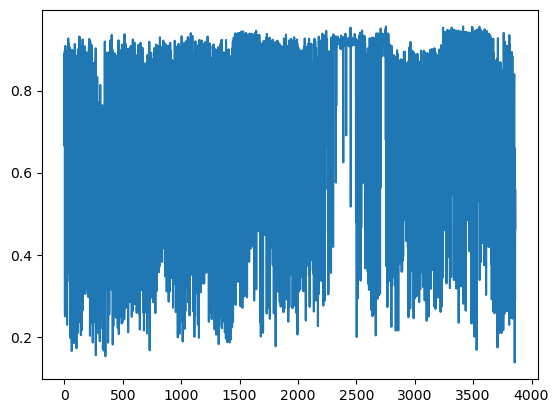

In [28]:
plt.plot(max_prob)

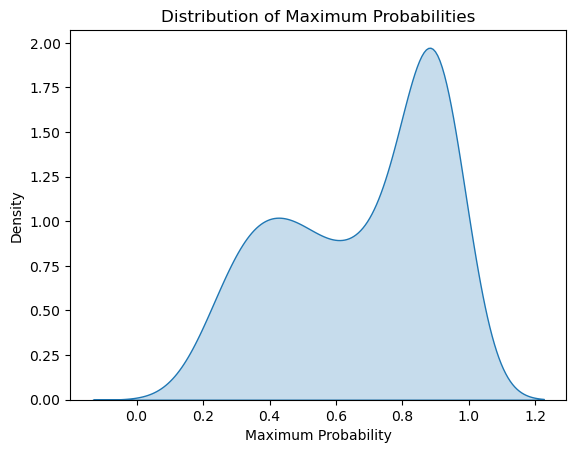

In [29]:
import seaborn as sns
sns.kdeplot(max_prob, bw_adjust=2, fill=True,)
plt.title("Distribution of Maximum Probabilities")
plt.xlabel("Maximum Probability")
plt.savefig("Maximum Probability.png")

In [30]:
real_label_reset = real_label.reset_index(drop=True)# Assuming max_prob is a torch.Tensor
max_prob_list = max_prob.tolist()  # Convert torch.Tensor to a list

# Display the new DataFrame
# Create a new DataFrame with columns from real_label and pred_label
new_df = pd.DataFrame({
    'Real Label': real_label_reset['cell_type'],
    'Predicted Label': pred_label[0],
    'Max Probability': max_prob_list
})

# Display the new DataFrame
new_df.set_index(input_query.obs_names)
print(new_df)

         Real Label             Predicted Label  Max Probability
0     Breast Cancer               Breast Cancer         0.887517
1     Breast Cancer               Breast Cancer         0.665320
2     Breast Cancer               Breast Cancer         0.825786
3     Breast Cancer               Breast Cancer         0.895880
4     Breast Cancer              Ovarian Cancer         0.273787
...             ...                         ...              ...
3857   Liver Cancer              Ovarian Cancer         0.383492
3858   Liver Cancer              Ovarian Cancer         0.347604
3859   Liver Cancer                 Lung Cancer         0.288106
3860   Liver Cancer  Endometrial/Uterine Cancer         0.559111
3861   Liver Cancer               Breast Cancer         0.462728

[3862 rows x 3 columns]


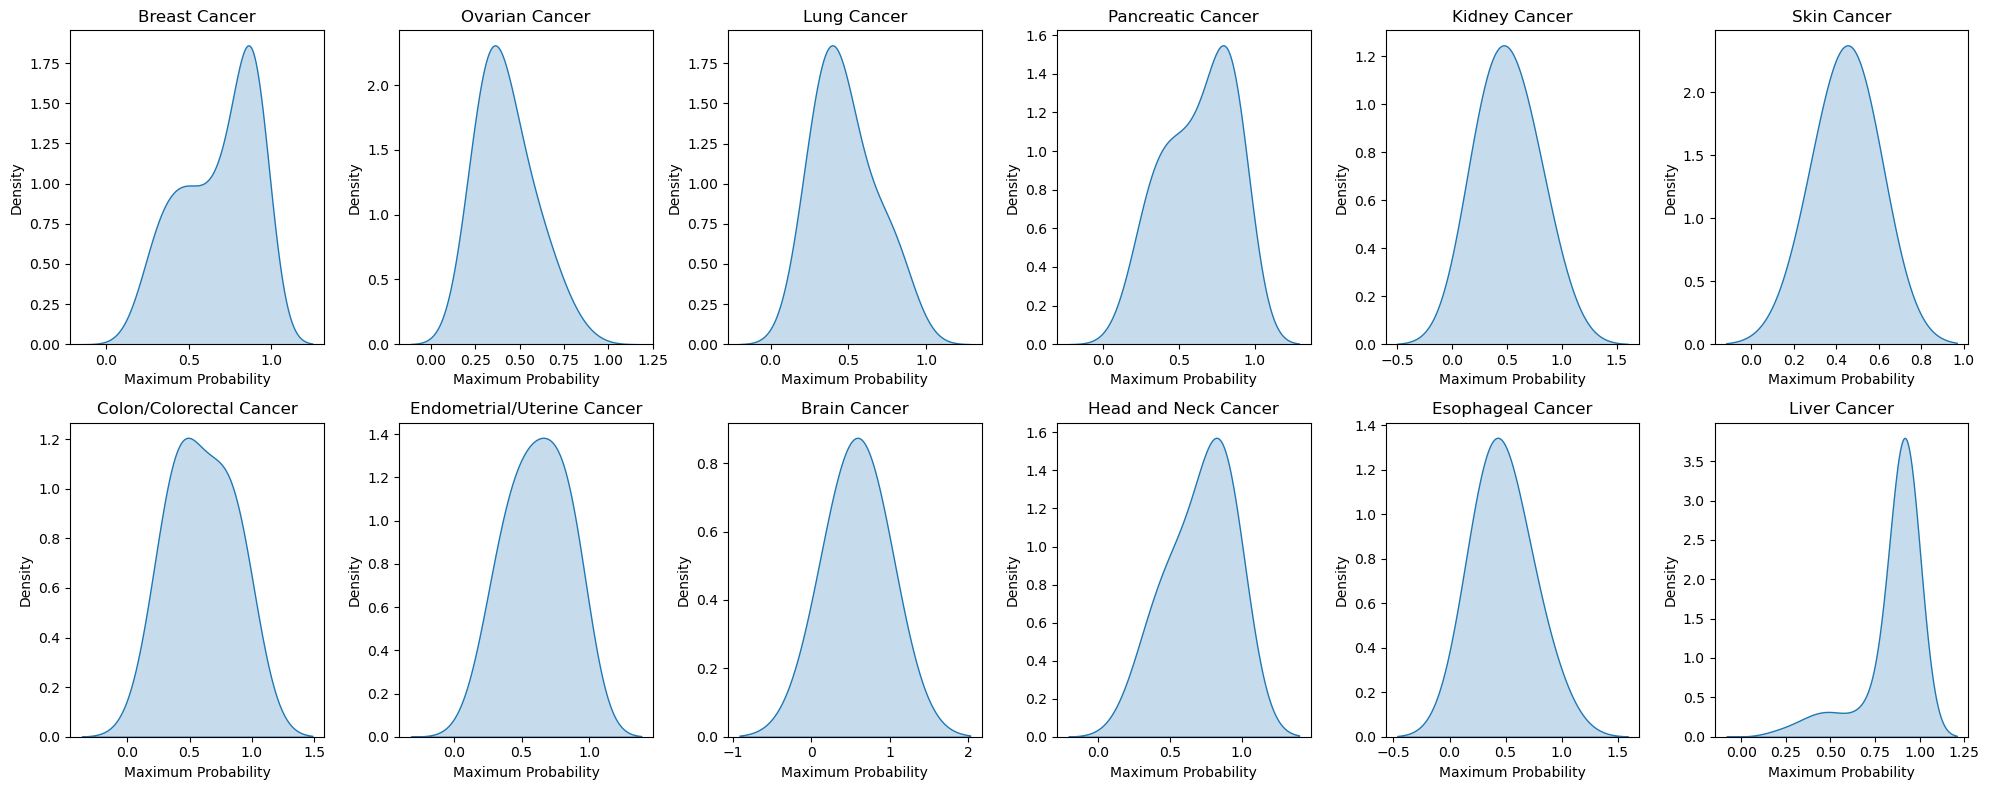

In [35]:
# Get unique predicted labels
unique_pred_labels = new_df['Predicted Label'].unique()

# Define the number of rows and columns for subplots
num_rows = 2
num_cols = 6
num_plots = num_rows * num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))

# Plot maximum probability distribution for each predicted class
for i, pred_label in enumerate(unique_pred_labels):
    # Calculate the row and column index for the current subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    # Filter the data for the current predicted label
    max_probs_class = new_df[new_df['Predicted Label'] == pred_label]['Max Probability']
    
    # Plot KDE plot for the maximum probabilities of the current predicted class
    sns.kdeplot(max_probs_class, bw_adjust=2, fill=True, ax=axes[row_idx, col_idx])
    
    
    # Set title and labels for the subplot
    axes[row_idx, col_idx].set_title(f"{pred_label}")
    axes[row_idx, col_idx].set_xlabel("Maximum Probability")
    axes[row_idx, col_idx].set_ylabel("Density")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



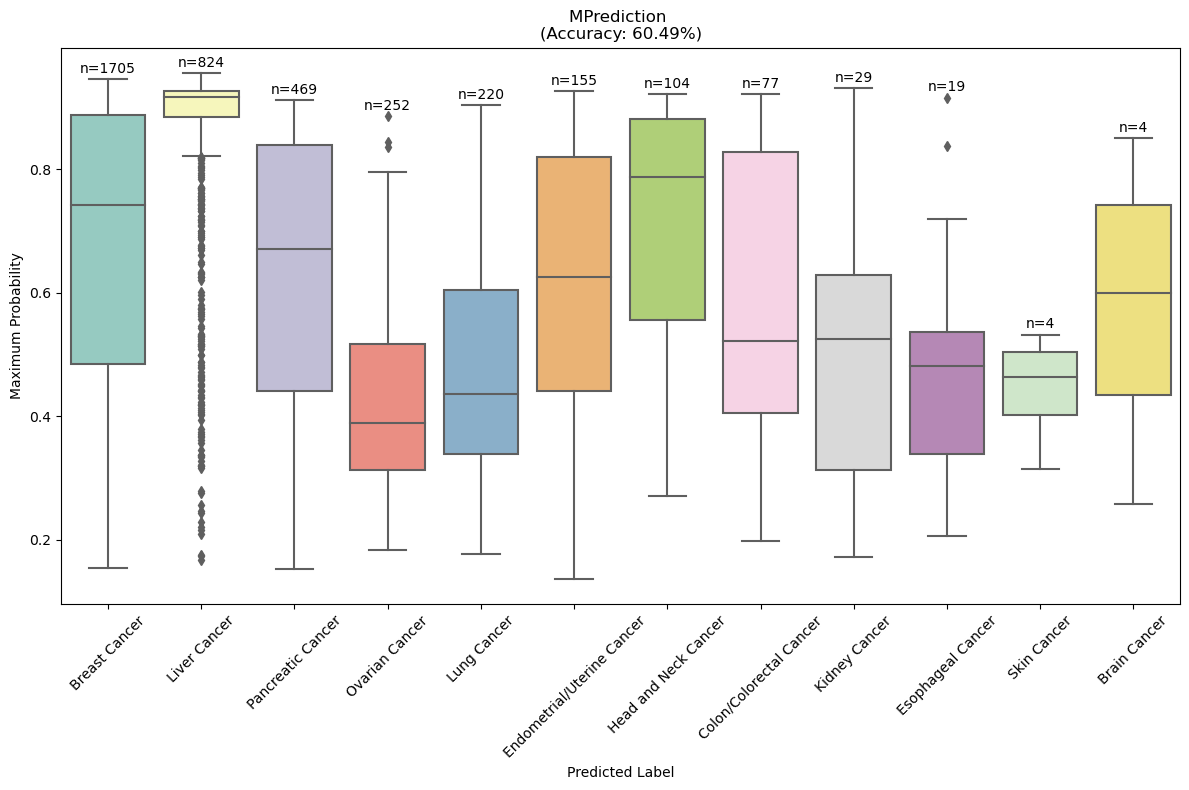

In [40]:
# Assuming you have the actual labels stored in 'Real Label' column
actual_labels = new_df['Real Label']

# Assuming you have the predicted labels stored in 'Predicted Label' column
predicted_labels = new_df['Predicted Label']

# Calculate accuracy
accuracy = (actual_labels == predicted_labels).mean()

# Determine the order of predicted labels based on frequency
predicted_label_order = new_df['Predicted Label'].value_counts().index

# Plot box plot for all predicted classes
plt.figure(figsize=(12, 8))

# Plot box plot for all predicted classes
sns.boxplot(data=new_df, x='Predicted Label', y='Max Probability', palette='Set3', order=predicted_label_order)

# Add annotations on top of each box to show frequency
for i, pred_label in enumerate(predicted_label_order):
    count = new_df[new_df['Predicted Label'] == pred_label]['Max Probability'].count()
    plt.text(i, new_df[new_df['Predicted Label'] == pred_label]['Max Probability'].max() + 0.01, f'n={count}', 
             horizontalalignment='center')

# Set title and labels
plt.title(f'MPrediction \n(Accuracy: {accuracy:.2%})')
plt.ylabel('Maximum Probability')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

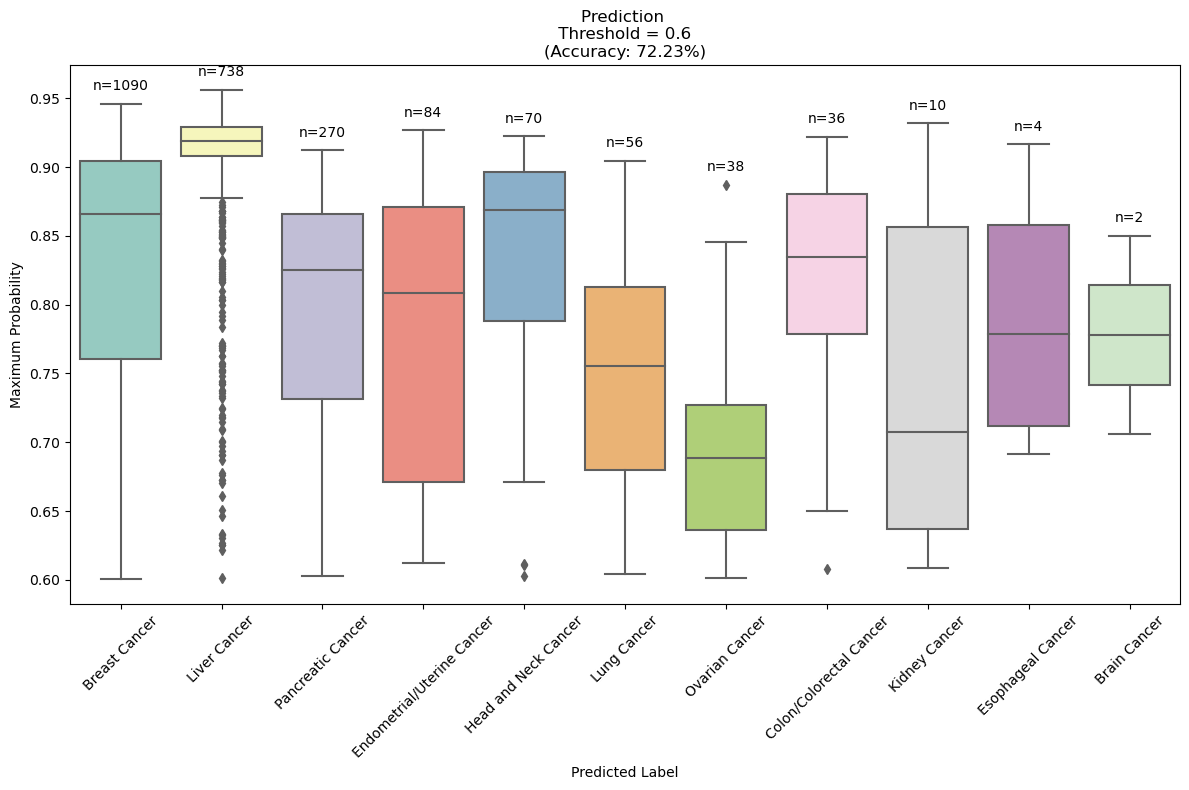

In [41]:
# Define the threshold for maximum probability
threshold = 0.6

# Filter out predictions below the threshold
filtered_df = new_df[new_df['Max Probability'] >= threshold]

# Assuming you have the actual labels stored in 'Real Label' column
actual_labels_filtered = filtered_df['Real Label']

# Assuming you have the predicted labels stored in 'Predicted Label' column
predicted_labels_filtered = filtered_df['Predicted Label']

# Calculate accuracy based on the filtered data
accuracy_filtered = (actual_labels_filtered == predicted_labels_filtered).mean()

# Determine the order of predicted labels based on frequency in the filtered data
predicted_label_order_filtered = filtered_df['Predicted Label'].value_counts().index

# Plot box plot for predicted classes with probabilities above the threshold
plt.figure(figsize=(12, 8))

# Plot box plot for predicted classes with probabilities above the threshold
sns.boxplot(data=filtered_df, x='Predicted Label', y='Max Probability', palette='Set3', order=predicted_label_order_filtered)

# Add annotations on top of each box to show frequency
for i, pred_label in enumerate(predicted_label_order_filtered):
    count = filtered_df[filtered_df['Predicted Label'] == pred_label]['Max Probability'].count()
    plt.text(i, filtered_df[filtered_df['Predicted Label'] == pred_label]['Max Probability'].max() + 0.01, f'n={count}', 
             horizontalalignment='center')

# Set title and labels
plt.title(f'Prediction \n Threshold = {threshold} \n(Accuracy: {accuracy_filtered:.2%})')
plt.ylabel('Maximum Probability')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

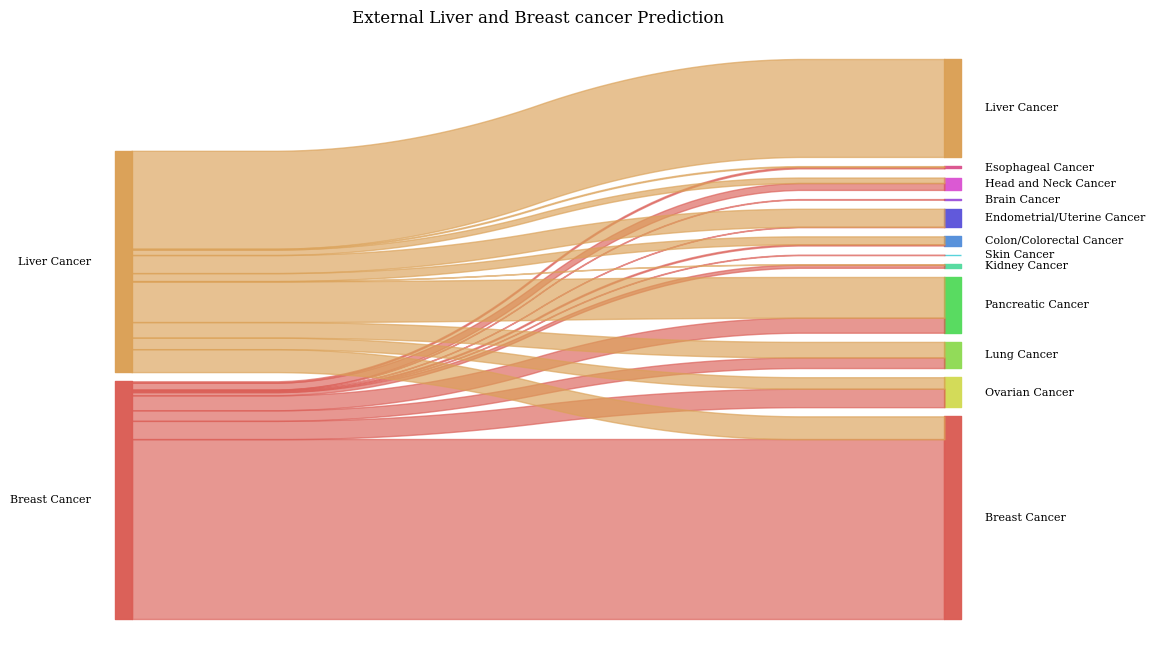

In [44]:
from pySankey.sankey import sankey

sankey(new_df["Real Label"], new_df["Predicted Label"], aspect=20, fontsize=8)
plt.title('External Liver and Breast cancer Prediction')
plt.gcf().set_size_inches((12,8))
plt.show()

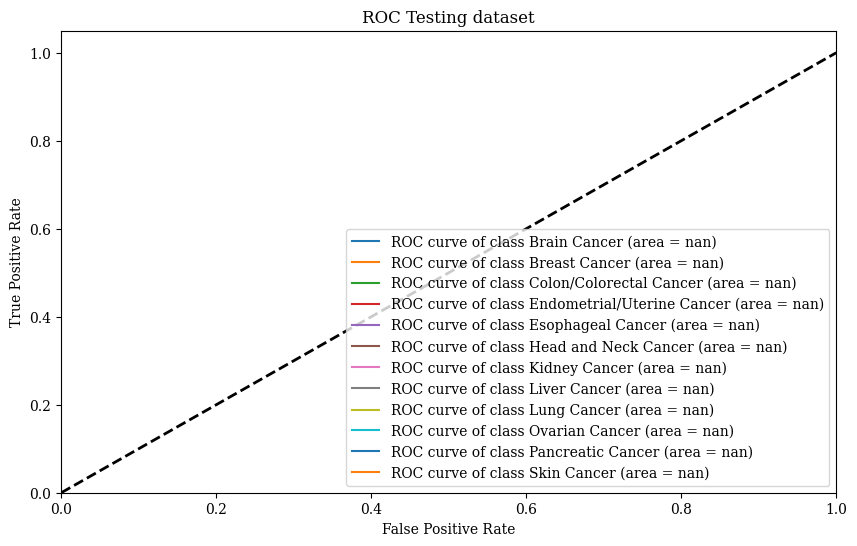

In [53]:
from sklearn.metrics import roc_curve, auc

trainy = pd.read_csv("./pretrain_less_class_2/trainy_pre.csv")
classes = len(np.unique(trainy['celltype_l2']))
# Assuming you have true labels and predicted probabilities
y_true = new_df['Real Label']  # True labels
y_score = prob.numpy()  # Predicted probabilities for each class

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(classes):  # classes is the number of classes in your problem
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve with class names
plt.figure(figsize=(10, 6))

# Convert class indices to class names using label encoder
class_names = le2.inverse_transform(np.arange(classes))

for i in range(classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Testing dataset')
plt.legend(loc="lower right")
plt.show()
